Dataset Description:-

See, fork, and run a random forest benchmark model through Kaggle Scripts
You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.


Data Fields:-
    
-- datetime - hourly date + timestamp  
--season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
--holiday - whether the day is considered a holiday
--workingday - whether the day is neither a weekend nor holiday
--weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
            2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
--temp - temperature in Celsius
--atemp - "feels like" temperature in Celsius
--humidity - relative humidity
--windspeed - wind speed
--asual - number of non-registered user rentals initiated
--registered - number of registered user rentals initiated
--count - number of total rentals


In [33]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
bike_data = pd.read_csv("train.csv")

## Quick Data Insights

In [35]:
bike_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [36]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [37]:
bike_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [63]:
for columns in bike_data:
    if columns not in ["count","casual","registered"]:
        unique_values = bike_data[columns].unique()
        print(columns,":-",unique_values)
        print("     ")
        print("--------------------------")

season :- [1 2 3 4]
     
--------------------------
holiday :- [0 1]
     
--------------------------
workingday :- [0 1]
     
--------------------------
weather :- [1 2 3 4]
     
--------------------------
temp :- [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3
 10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46 21.32 22.96 23.78
 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7  30.34 31.16 29.52
 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54  1.64  0.82 39.36
 41.  ]
     
--------------------------
atemp :- [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455
 11.365 10.605  9.85   8.335  6.82   5.305  6.06   9.09  12.12   7.575
 15.91   3.03   3.79   4.545 15.15  18.18  25.    26.515 27.275 29.545
 23.485 25.76  31.06  30.305 24.24  18.94  31.82  32.575 33.335 28.79
 34.85  35.605 37.12  40.15  41.665 40.91  39.395 34.09  28.03  36.365
 37.88  42.425 43.94  38.635  1.515  0.76   2.275 43.18  44.695 45.455]
     
---------

In [66]:
for columns in bike_data:
    if columns not in ["count","casual","registered","temp","atemp"]:
        unique_values = bike_data[columns].value_counts()
        print(columns,":")
        print(unique_values)
        print("     ")
        print("--------------------------")

season :
4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64
     
--------------------------
holiday :
0    10575
1      311
Name: holiday, dtype: int64
     
--------------------------
workingday :
1    7412
0    3474
Name: workingday, dtype: int64
     
--------------------------
weather :
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64
     
--------------------------
humidity :
88    368
94    324
83    316
87    289
70    259
     ... 
8       1
10      1
97      1
96      1
91      1
Name: humidity, Length: 89, dtype: int64
     
--------------------------
windspeed :
0.0000     1313
8.9981     1120
11.0014    1057
12.9980    1042
7.0015     1034
15.0013     961
6.0032      872
16.9979     824
19.0012     676
19.9995     492
22.0028     372
23.9994     274
26.0027     235
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      58
39.0007      27
36.9974      22
43.0006      12
40.9973      11
43.9989       8
46.0022       3

## Data Preprcessing

In [38]:
bike_data.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [45]:
bike_data["datetime"]

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
10881    2012-12-19 19:00:00
10882    2012-12-19 20:00:00
10883    2012-12-19 21:00:00
10884    2012-12-19 22:00:00
10885    2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: object

In [46]:
bike_data.drop("datetime", axis=1, inplace = True)

In [47]:
bike_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Data Visualization

In [70]:
category = ["season","holiday","workingday","weather"]
continuous = ["temp","atemp","humidity","windspeed","casual","registered"]

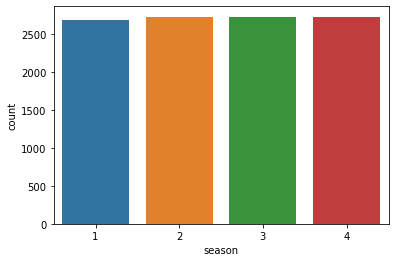

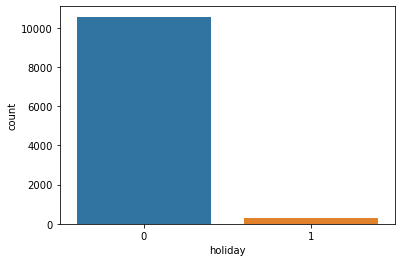

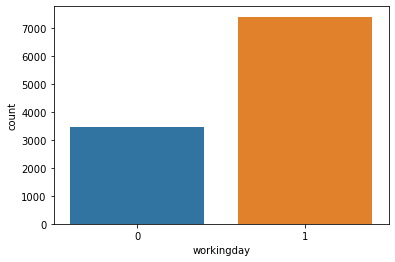

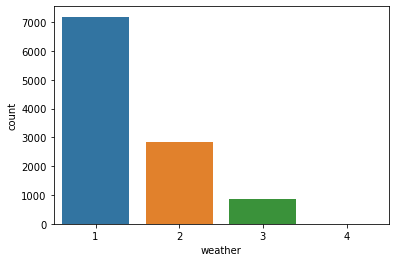

In [71]:
for column in category:
    sns.countplot(data = bike_data, x=column)
    plt.show()

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


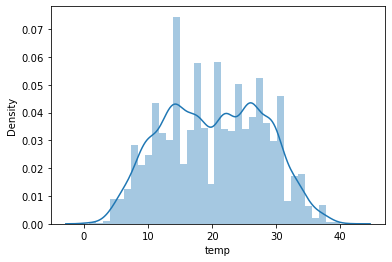

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


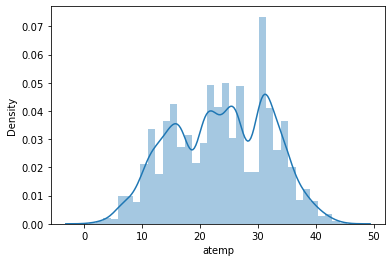

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


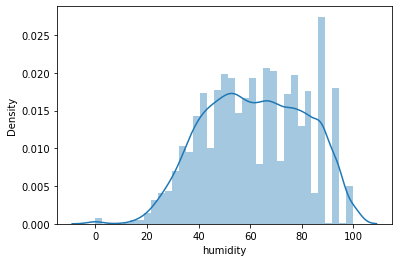

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


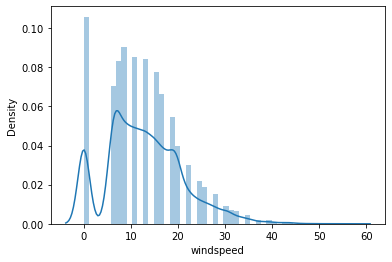

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


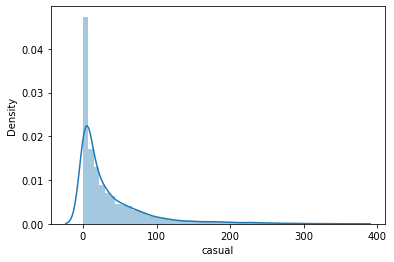

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


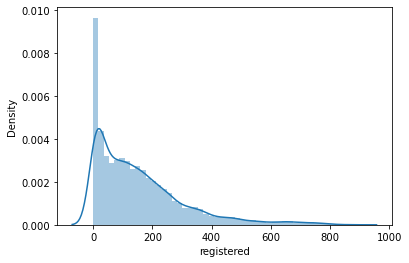

In [83]:
for column in continuous:
    sns.distplot(bike_data[column])
    plt.show()

In [ ]:
for column in continuous:
    sns.boxplt(data=bike_data, x=column)